# tennis_collab

`tennis_collab` is a deep deterministic policy gradeint (DDPG) agent trained to play [Unity ML-Agent Toolkit](https://github.com/Unity-Technologies/ml-agents)'s [Tennis](https://www.youtube.com/watch?v=WprTJwaK510). Instead of training the agents to *compete* against each other, we trained them using **the sum of rewards** for them to *cooperate* with each other for the longest rally possible. The model solved the environment (scoring a 100-play moving average across all agents of 0.5 or above) in 403 episodes (roughly 8 minutes). The weights of trained network are saved as `actor_optimal.pth` and `critic_optimal.pth`.

## Imports

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import trange
from collections import deque

#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#RL
from network import Actor, Critic
from memory import VanillaMemory
# from agent import Agent

## Environment

The environment consists of 24 values that describe a state (8 values stacked over 3 timesteps) and 2 values that describe an action. The state represents the position and velocity of the ball and racket. The action is  movement toward (or away from) the net, and jumping. The episode ends after when the ball goes out of bound. If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. The environment is considered solved when the average score of the last 100 episodes exceed 0.5.

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux_NoVis/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print(f'Number of agents: {num_agents}')

# size of each action
action_size = brain.vector_action_space_size
print(f'Size of each action: {action_size}')

# examine the state space 
states = env_info.vector_observations
state_size = states.shape
print(f'There are {states.shape[0]} agents. Each observes a state with length: {state_size}')
print(f'The state looks like for the first agent: {states[0]}')

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: (2, 24)
The state looks like for the first agent: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


## Agent

We adopted the DDPG agent used to train the Bipedal-Walker in [Udacity DRLND repository](https://github.com/udacity/deep-reinforcement-learning/tree/master/ddpg-bipedal) with some changes to the hyperparameters as follows. 

The twist here is that **this is NOT a multi-agent problem**. Our goal is to have **the longest rally possible**. Instead of thinking of the problem as two players holding two bats playing against each other, we can think of the bats as held by two hands of one person trying to balance the ball for as long as possible. Therefore, instead of `rewards` we use **the sum of the rewards** as `fake_rewards` for the agent. This hopefully will motivate the agent to *hit an easy ball* for its opponent.

We also collected the losses of actor and critic to help with finetuning the agent.

In [5]:
mem = VanillaMemory(int(1e5), seed = 0)
agent = Agent(state_size=24, action_size=2, replay_memory=mem, random_seed=0, 
              nb_agent = 2, bs = 128,
              gamma=0.99, tau = 1e-1, lr_actor=5e-4, lr_critic=1e-3, wd_actor=0, wd_critic=0,
              clip_actor = None, clip_critic = 1, update_interval = 1, update_times = 1)

In [6]:
scores = []
moving_scores = []
scores_avg = deque(maxlen=100)
n_episodes = 1000
nb_agent = 2

for episode in trange(n_episodes):
    #get initial states
    env_info = env.reset(train_mode=True)[brain_name]            
    states = env_info.vector_observations
    score = np.zeros(nb_agent)
    agent.reset_noise()                                             

    while True:
        #random actions
        actions = np.random.randn(nb_agent, action_size)
        actions = np.clip(actions, -1, 1)  
        #agent action
        actions = agent.act(states)
        env_info = env.step(actions)[brain_name]                 # env step                    
        next_states = env_info.vector_observations               # get the next state        
        rewards = env_info.rewards                               # get the reward        
        #fake rewards being the sum of all rewards since they are essentially one person
        fake_rewards = [sum(rewards) for i in rewards]
        dones = env_info.local_done                              # see if episode has finished        
        agent.step(states, actions, fake_rewards, next_states, dones) # agent step
        score += rewards                                         # update the score
        states = next_states                                     # roll over the state to next time step        
        if np.any(dones):                                        # exit loop if episode finished        
            break     
            
    #book keeping
    scores.append(np.max(score))
    scores_avg.append(np.max(score))
    moving_scores.append(np.mean(scores_avg))

    #print scores intermittenly
    if episode % 100 ==0: print(f'Episode: {episode} Score: {np.max(score)} Average Score: {np.mean(scores_avg)}')

    #break if done
    if (np.mean(scores_avg) > 0.5) & (len(scores_avg) == 100):
        print(f'Environment solved in {episode} episodes! Average Score: {np.mean(scores_avg)}')
        break    


  0%|          | 1/1000 [00:00<02:53,  5.77it/s]

Episode: 0 Score: 0.0 Average Score: 0.0


 10%|█         | 101/1000 [00:30<04:28,  3.35it/s]

Episode: 100 Score: 0.0 Average Score: 0.03240000052377581


 20%|██        | 201/1000 [01:32<06:06,  2.18it/s]

Episode: 200 Score: 0.10000000149011612 Average Score: 0.11610000176355242


 30%|███       | 301/1000 [03:48<08:50,  1.32it/s]

Episode: 300 Score: 0.10000000149011612 Average Score: 0.2542000038363039


 40%|████      | 401/1000 [08:17<12:23,  1.24s/it]

Episode: 400 Score: 0.20000000298023224 Average Score: 0.49750000746920703


 40%|████      | 403/1000 [08:20<12:20,  1.24s/it]

Environment solved in 403 episodes! Average Score: 0.502400007545948


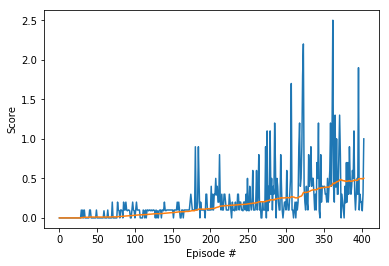

In [11]:
plt.plot(scores)
plt.plot(moving_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()    

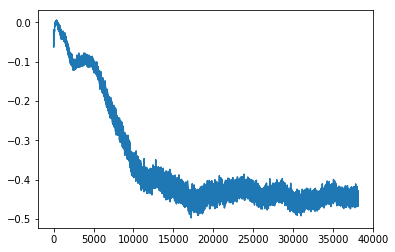

In [12]:
plt.plot(agent.actor_losses)

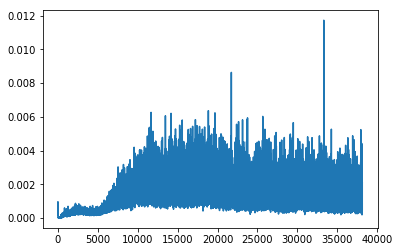

In [13]:
plt.plot(agent.critic_losses)

## Save Model Weights

In [14]:
#save models
torch.save(agent.actor_local.state_dict(),'actor_optimal.pth')
torch.save(agent.critic_local.state_dict(),'critic_optimal.pth')

## Future Works

* For this specific problem set, there is not much we can apply a multi-agent model. What I would like to try is changing the problem to **creating an agent that tries to win as fast as possible** thus creating a competitive instead of cooperative environment. In that case, multi-agent deep deterministic policy gradient (MADDPG) with two actor models and shared memory and critic model should be a suitable model to start with. 
* As time goes on, annealing tau, update interval/times should help stabilize the training.
* As mentioned when I submitted the `Reacher` project, I think DDPG's biggest flaw is its lack of exploration options (we only have OU Noise for that as I understand), we should have some other means of doing this such as noisy linear units.